# Reproducible MRI Reconstruction with BART

[Jon Tamir](mailto:jtamir@utexas.edu), Chandra Family Department of Electrical and Computer Engineering, The University of Texas at Austin

Based off of previous tutorials from other contributors:  

### MRITogether 2021
[MRITogether 2021 Tutorial](https://github.com/mrirecon/bart-workshop/tree/master/mri_together_2021)

[Martin Uecker](mailto:uecker@tugraz.at)$^{\dagger,*,+}$, [Nick Scholand](mailto:scholand@tugraz.at)$^{*,+}$, [Moritz Blumenthal](mailto:moritz.blumenthal@med.uni-goettingen.de)$^*$, [Xiaoqing Wang](mailto:xiaoqing.wang@med.uni-goettingen.de)$^{*,+}$

$^{\dagger}$Graz University of Technology, $^*$University Medical Center Göttingen, $^+$German Centre for Cardiovascular Research, Partner Site Göttingen

### BART Webinar 1, 2020
[BART Webinar 1 Tutorial](https://github.com/mrirecon/bart-webinars/tree/master/webinar1)

[Max Litster](mailto:maxlitster@berkeley.edu), UC Berkeley

The purpose of this notebook is to introduce the [BART toolbox](https://mrirecon.github.io/bart), and its use as a tool for reproducible research in MRI.

We recommend checking other points of reference, primarily available in the following locations:
- [BART Workshops](https://github.com/mrirecon/bart-workshop)
- [BART Webinars](https://github.com/mrirecon/bart-webinars) (and [webinar recordings](https://www.youtube.com/@bart-toolboxdepartmental7435/playlists)\)


## Installation




### Local Usage
- Install bart from its [github repository](https://github.com/mrirecon/bart)
- Set the `TOOLBOX_PATH` to the BART directory and add it to the `PATH`

```bash
export TOOLBOX_PATH=/path/to/bart  
export PATH=$TOOLBOX_PATH:$PATH
```

Although the simplest way to call the BART CLI tools is from a terminal, there are also wrapper functions that allow the tools to be used from Matlab and Python. These are located under the `$TOOLBOX_PATH/matlab` and `$TOOLBOX_PATH/python` directories.

### Online Usage
We recommend running BART locally when possible. For demonstration purposes, MyBinder and Google Colaboratory can be used to access a Jupyter instance with BART with a browser. In the following we install and configure BART for both.

The following code will automatically detect which service you are using.

In [1]:
# Check if notebook runs on colab
import sys, os

os.environ['COLAB'] = 'true' if ('google.colab' in sys.modules) else 'false'
os.environ['CUDA'] = '0'

#### BART Installation

Here we install BARTs dependencies, clone its repository from github, and compile it.

In [2]:
%%bash

# MyBinder has BART already installed via the container
if $COLAB; then

  # Install BARTs dependencies
  apt-get install -y make gcc libfftw3-dev liblapacke-dev libpng-dev libopenblas-dev &> /dev/null

  # Clone Bart
  [ -d /content/bart ] && rm -r /content/bart
  git clone https://github.com/mrirecon/bart/ bart &> /dev/null
fi

In [3]:
%%bash

if $COLAB; then

  cd bart

  # Configuration
  COMPILE_SPECS=" PARALLEL=1
                  OPENBLAS=1
                  BLAS_THREADSAFE=1"

  printf "%s\n" $COMPILE_SPECS > Makefiles/Makefile.local

  # Compile BART
  make &> /dev/null && echo ok
fi

#### Setup Environment for BART

After downloading and compiling BART, the next step simplifies the handling of BARTs command line interface inside an ipyhton jupyter notebook. We add the BART directory to the PATH variable and include the python wrapper for reading *.cfl files:

In [4]:
if os.environ['COLAB'] == 'true':
    os.environ['TOOLBOX_PATH'] = "./bart"
    os.environ['PATH'] = os.environ['TOOLBOX_PATH'] + ":" + os.environ['PATH']
    sys.path.append(os.environ['TOOLBOX_PATH'] + "/python/")

Check BART setup:

In [5]:
%%bash
echo "# BART version: "
bart version

# BART version: 
Builtin found: version
v0.9.00


### Setup Visualization Helper

For this tutorial we will visualize some images. Therefore, we need a helper function and some python libraries.


In [6]:
# More python libraries
import cfl
import numpy as np

from matplotlib import pyplot as plt
from matplotlib import cm
from mpl_toolkits.axes_grid1 import make_axes_locatable
from IPython.display import Image

def bart_plot(data, title=None, vmin=None, vmax=None, cmap='gray', cbar_label='', mag=True, fsize=10):

    # Import data
    data = np.abs(data) if mag else data

    fig = plt.figure(figsize=(fsize,fsize))
    ax1 = fig.add_subplot(111)
    im = ax1.imshow(data, interpolation='nearest', cmap=cmap, vmin=vmin, vmax=vmax)
    if title:
      plt.title(title)
    # Style settings
    divider = make_axes_locatable(ax1)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    cbar = plt.colorbar(im, cax=cax)
    cbar.set_label(cbar_label)
    cbar.ax.tick_params()

    ax1.set_yticklabels([])
    ax1.set_xticklabels([])
    ax1.xaxis.set_ticks_position('none')
    ax1.yaxis.set_ticks_position('none')
    ax1.set_axis_off()


    plt.show()

### Download Supporting Materials
For this tutorial, we also need to download some data from the GitHub repository.

In [7]:
%%bash

# Download the required supporting material if it is not already there
[ ! -f data.zip ] && wget -q https://github.com/mrirecon/bart-workshop/raw/master/mri_together_2023/data.zip
unzip -n data.zip

Archive:  data.zip


## BART Fundamentals
BART provides a number of tools for MRI image reconstruction and multi-dimensional array manipulation. We can get a list of them by running `bart` with no arguments.

Note: The ! character indicates that the following cell should be executed in bash vs. the native python kernel. It is not necessary when running BART commands from your terminal.



In [8]:
# get a list of BART commands by running bart with no arguments:
! bart

Usage: bart [-l,--loop d] [-p,--parallel-loop d] [-s,--start d0:d1:...:dN] [-e,--end d0:d1:...:dN] [-t,--threads d] [-r,--ref-file <file>] [-M,--mpi] [-S] ...
BART. Available commands are:
avg         bench       bin         bitmask     cabs        calc        
caldir      calmat      carg        casorati    cc          ccapply     
cdf97       circshift   conj        conv        conway      copy        
cpyphs      creal       crop        delta       ecalib      ecaltwo     
epg         estdelay    estdims     estshift    estvar      extract     
fakeksp     fft         fftmod      fftrot      fftshift    filter      
flatten     flip        fmac        fovshift    homodyne    ictv        
index       invert      itsense     join        looklocker  lrmatrix    
mandelbrot  measure     mip         mnist       moba        mobafit     
morphop     multicfl    nlinv       nlmeans     nnet        noise       
normalize   nrmse       nufft       nufftbase   onehotenc   ones        
pattern 

### BART Command Structure

All BART commands are structured in the following way:

> **`bart`** + **`command`** + **`options`** + **`input / output`**

Each BART command consists of a number of optional arguments, followed by input and output files. To get some information about a command, use the -h flag. Optional arguments are indicated by brackets, and files are indicated by carrot symbols.

For example, the following command demonstrates the full suite of options for generating a numerical phantom in the image or k-space domain:

In [9]:
! bart phantom -h

Builtin found: phantom
Usage: phantom [-s d] [-S d] [-k] [-t <file>] [-G] [-T] [--NIST] [--SONAR] [--BRAIN] [--ELLIPSOID] [--ellipsoid_center d:d:d] [--ellipsoid_axes f:f:f] [-N d] [-B] [--FILE <file>] [-x d] [-g d] [-3] [-b] [-r d] [--rotation-angle f] [--rotation-steps d] [--coil ...] <output> 

Image and k-space domain phantoms.

-s nc                       nc sensitivities
-S nc                       Output nc sensitivities
-k                          k-space
-t file                     trajectory
-G                          geometric object phantom
-T                          tubes phantom
--NIST                      NIST phantom (T2 sphere)
--SONAR                     Diagnostic Sonar phantom
--BRAIN                     BRAIN geometry phantom
--ELLIPSOID                 Ellipsoid.
--ellipsoid_center d:d:d    x,y,z center coordinates of ellipsoid.
--ellipsoid_axes f:f:f      Axes lengths of ellipsoid.
-N num                      Random tubes phantom with num tubes
-B              

The `phantom` tool includes the option `-k` to create it in k-space, and `-x` to specify the size.

## Python Bindings

BART comes equipped with Python bindings that easily integrate with popular scientific computing libraries in Python. This tutorial introduces the structure of the BART python module.

If you're running in MyBinder, the paths should be updated and you should be all set to run the following demos.

If you are running locally, you will need to directly import the bart module. To do this, you can add BART's python directory to your `PYTHONPATH` environment variable. Add the following line to your .bashrc to do this:

```bash
export PYTHONPATH="${TOOLBOX_PATH}/python:$PYTHONPATH"
```

Where `TOOLBOX_PATH` is the location of your BART install.

This way, we can import the bart module as well as cfl, our utility file for dealing with BART's data format: a .hdr header file and a .cfl file of complex-float data.

If you're already running the demo in MyBinder or Colab, you may have to manually modify the path, which we do here:


In [10]:
if os.environ['COLAB'] == 'true':
    import os
    bart_python_path = '{}/python'.format(os.environ['TOOLBOX_PATH'])
    sys.path.append(bart_python_path)

After having updated your `PYTHONPATH`, the following cells should execute error-free:

In [11]:
from bart import bart
import cfl

### BART Python Command Structure
The `bart` module allows a user to execute any BART command-line tool via the following format:

```python
<outputs> = bart(<nargout>, <command>, <arguments>, ...)
```
where:
- `<outputs>` are the data file outputs of a BART command
- `<nargout>` is the number of outputs expected by the command
- `<command>` is the command string with flags
- `<arguments>` are the data files passed in for use in the function

Similar to the bash interface, we can also get the help string in a similar way:

In [12]:
bart(0, 'phantom -h')

Builtin found: phantom
Usage: phantom [-s d] [-S d] [-k] [-t <file>] [-G] [-T] [--NIST] [--SONAR] [--BRAIN] [--ELLIPSOID] [--ellipsoid_center d:d:d] [--ellipsoid_axes f:f:f] [-N d] [-B] [--FILE <file>] [-x d] [-g d] [-3] [-b] [-r d] [--rotation-angle f] [--rotation-steps d] [--coil ...] <output> 

Image and k-space domain phantoms.

-s nc                       nc sensitivities
-S nc                       Output nc sensitivities
-k                          k-space
-t file                     trajectory
-G                          geometric object phantom
-T                          tubes phantom
--NIST                      NIST phantom (T2 sphere)
--SONAR                     Diagnostic Sonar phantom
--BRAIN                     BRAIN geometry phantom
--ELLIPSOID                 Ellipsoid.
--ellipsoid_center d:d:d    x,y,z center coordinates of ellipsoid.
--ellipsoid_axes f:f:f      Axes lengths of ellipsoid.
-N num                      Random tubes phantom with num tubes
-B              

### Create phantoms

We will use the phantom tool to create various types of phantoms

Builtin found: phantom


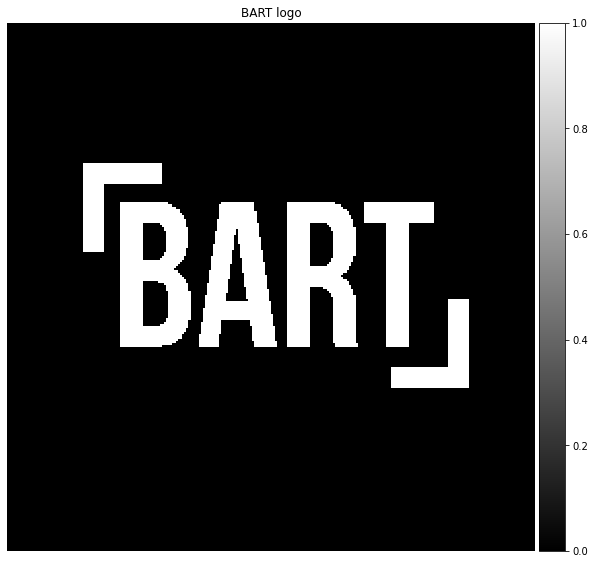

Builtin found: phantom


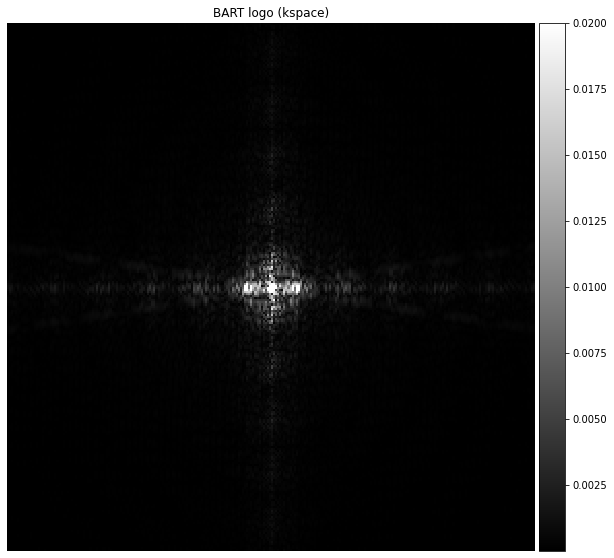

In [13]:
# Create a "BART logo" phantom in the image domain
bart_phantom = bart(1, 'phantom -x 256 -B').T

bart_plot(bart_phantom, title='BART logo')


# Create a "BART logo" phantom in k-space
bart_phantom_ksp = bart(1, 'phantom -x 256 -B -k').T

bart_plot(bart_phantom_ksp, title='BART logo (kspace)', vmax=.02)


## File formats and metadata

BART data files are (typically) stored in two files, a header (`.hdr`) file which contains metadata (dimensions, file type, etc.) and a complex float (`.cfl`) file which contains the raw data. The header file can be opened and read as a normal text file, while the raw data is a binary file. The raw data is a multi-dimensional array of single-precision complex floats, stored in row-major order with interleaved real and imaginary components.

A Note about data formats: Saving and loading files are not Python in the purest sense, in that data is not stored in RAM the entire time during execution. Under the hood, the Python bindings are writing .hdr/.cfl files to and from the disk. A RAM disk can be used if users are looking to improve performance in this aspect.

### Writing to and from `.cfl` files

The `cfl` Python library has some helpful tools to save or load BART data into a numpy-compatible format. In the first example, we will create a complex float array in numpy and then load it into BART from the command line. In the second example, we generate an array via the CLI and load it into Python via the cfl library.

In [14]:
A = np.array([1 + 1j, 2 + 3j, 3 + 5j])
cfl.writecfl('A', A)
! ls A.*
! bart show A

A.cfl  A.hdr
Builtin found: show
+1.000000e+00+1.000000e+00i	+2.000000e+00+3.000000e+00i	+3.000000e+00+5.000000e+00i


Note that when calling BART functions from the command-line, you do not need to include the extension. This is because BART understands to look for both the `.cfl` and `.hdr` files.

In [15]:
! bart ones 2 3 3 B
B = cfl.readcfl('B')
B

Builtin found: ones


array([[1.+0.j, 1.+0.j, 1.+0.j],
       [1.+0.j, 1.+0.j, 1.+0.j],
       [1.+0.j, 1.+0.j, 1.+0.j]], dtype=complex64)

Because the header file is a text file, we can directly print it:

In [16]:
! cat B.hdr

# Dimensions
3 3 
# Command
ones 2 3 3 B 
# Files
 >B
# Creator
BART v0.9.00


Although not discussed here, BART can write to other file formats that might not have a text header. Thus, it is better to use the show command:

In [17]:
! bart show -m B

Builtin found: show
Type: complex float
Dimensions: 16
AoD:	3	3	1	1	1	1	1	1	1	1	1	1	1	1	1	1


Our dataset is 16-dimensional, but only the first two dimensions are non-singleton.

By convention, the dimensions are `[X, Y, Z, C, M, T, F, ...]`,
where `(X, Y, Z)` are the spatial matrix dimensions,  
`C` and `M` are the coil dimensions and ESPIRiT maps dimensions, respectively,  
`T` and `F` are used for echo times and coefficient dimensions,   
followed by other higher order dimensions such as flow encoding, etc.

When using the Python interface, note that higher-order singleton dimensions will be squeezed and thus might not show up as 16-dimensional.

### Using Bitmasks to select dimensions
Let's reconstruct our BART k-space phantom using a inverse Fast Fourier Transform (IFFT). Let's first see the options of the FFT command

In [18]:
bart(0, 'fft -h')

Builtin found: fft
Usage: fft [-u] [-i] [-n] bitmask <input> <output> 

Performs a fast Fourier transform (FFT) along selected dimensions.

-u    unitary
-i    inverse
-n    un-centered
-h    help


The FFT command takes some optional arguments. It then takes three required arguments: `bitmask`, `<input>`, and `<output`>.

In [19]:
# check the shape of our BART phantom
print(bart_phantom_ksp.shape)

(256, 256)


Builtin found: fft


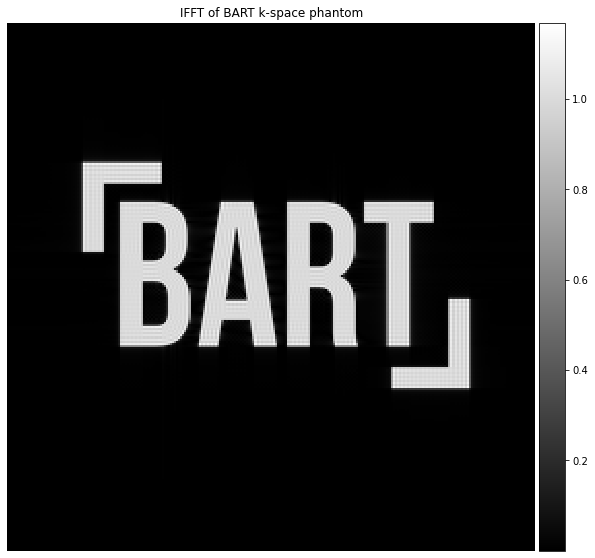

In [20]:
# Perform IFFT reconstruction

bart_phantom_rec = bart(1, 'fft -i 3', bart_phantom_ksp)
bart_plot(bart_phantom_rec, 'IFFT of BART k-space phantom')

Thus, we performed an inverse (`-i`) Fast Fourier Transform on the image dimensions **`(0, 1)`** specified by the bitmask **`3`**.


BART loops over dimensions selected by *bitmasks*. This is a powerful approach for perfoming multi-dimensional operations, as most tools will work on arbitrarily chosen dimensions.  

In our case, we wanted to perform an iFFT along dimensions 0 and 1, and the corresponding bitmask is calculated as:  
<center>
$ \text{bitmask}=2^{~0} + 2^{~1} = 3$
</center> <br>
BART also provides a command-line tool to calculate the bitmasks for specific dimensions.

In [21]:
# Calculate bitmask for active dimensions 0 and 1
! bart bitmask 0 1

Builtin found: bitmask
3


Let's compare the reconstructed BART phantom to the original image-domain phantom.

First we will create a difference array by subtracting the two images.

Next we will concatenate the  arrays along the second dimension so that we can plot them as one row:


(256, 768)


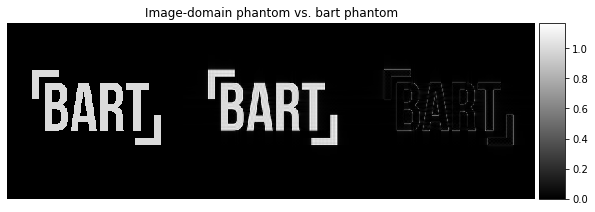

In [22]:
err_rec = bart_phantom - bart_phantom_rec
phantom_compare = np.concatenate((bart_phantom, bart_phantom_rec, err_rec), 1)
print(phantom_compare.shape)
bart_plot(phantom_compare, title='Image-domain phantom vs. bart phantom')


**Question: why are the two images not identical?**

## BART Examples


### Multi-coil Shepp Logan phantom

A complete tutorial for creating and reconstructing phantom data can be found in the [1st BART Webinar Materials](https://github.com/mrirecon/bart-webinars/blob/master/webinar1/day1_advanced_recon.ipynb)

We start with a simple example that already demonstrates some useful functions in BART:

- Creation of synthetic k-space data using the `phantom` tool
- Creation of subsampling patterns using the `usamp` tool
- Calibration of sensitivities using ESPIRIT using the `ecalib` tool
- Parallel imaging reconstruction using the `pics` tool

On the first step, we will create synthetic multi-coil k-space data using the `phantom` tool. We use the '-k' option to specify that we want to simulate k-space data, the -x option to set the matrix size and -s to set the number of coils.

In [23]:
# convenience function for unraveling a multi-coil array for plotting
def unravel(arr):
  return np.reshape(arr.transpose((0,3,1,2)), (arr.shape[0], np.prod(arr.shape[1:])))

Builtin found: phantom
(256, 256, 1, 8)


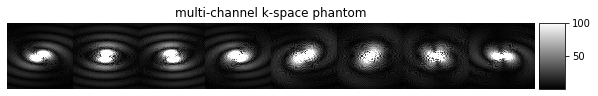

In [24]:
num_coils = 8
num_samples = 256

# create fully-sampled Cartesian multi-coil phantom in k-space
shepp = bart(1, 'phantom -k -x {} -s {}'.format(num_samples, num_coils))
print(shepp.shape)

bart_plot(unravel(shepp), title='multi-channel k-space phantom', vmax=100)

Next, we create a subsampling pattern. We can use BART to create sampling patterns suitable for 3D Cartesian imaging using the `poisson` and `upat` commands. Of course, we can use any tools we want to create them. Here, I will show off some of BART's other tools to create an equispaced 2D sampling pattern with a fully sampled center. This is of course not the most efficient way to create it -- it's just a nice way to showcase the tools.

Builtin found: ones
(256, 20)
Builtin found: resize
(256, 256)
Builtin found: zeros
(256, 1)
Builtin found: ones
(256,)
(256, 2)
Builtin found: repmat
(256, 2, 128)
Builtin found: reshape
(256, 256)


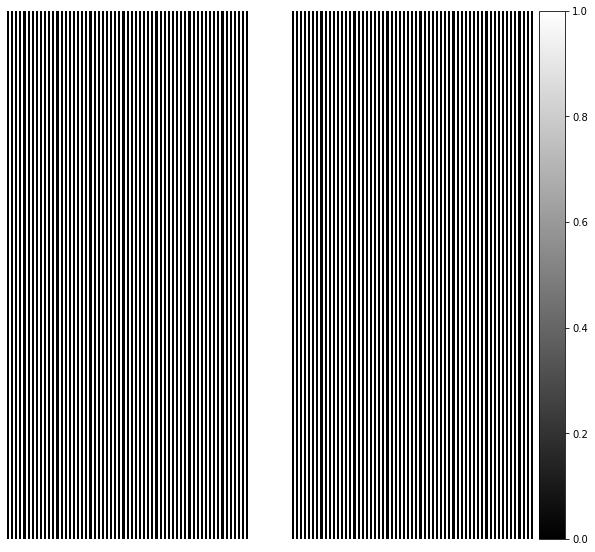

In [25]:
acs_size = 20
phase_accel = 2

# create a fully sampled ACS region
if acs_size > 0:
  acs_array = bart(1, 'ones 2 {} {}'.format(num_samples, acs_size))
else:
  acs_array = bart(1, 'zeros 2 {} {}'.format(num_samples, 2))
print(acs_array.shape)

acs_region = bart(1, 'resize -c 1 {}'.format(num_samples), acs_array)
print(acs_region.shape)


# create a zeros array of size phase_accel - 1
zeros_array = bart(1, 'zeros 2 {} {}'.format(num_samples, phase_accel - 1))
if phase_accel == 2:
  zeros_array = zeros_array[:,None]
print(zeros_array.shape)

# create a ones array of size 1 and concatenate with zeros_array
ones_array = bart(1, 'ones 2 {} 1'.format(num_samples, 1))
print(ones_array.shape)
zo_array = np.concatenate((zeros_array, ones_array[:,None]), 1)
print(zo_array.shape)

# replicate the zo_array to create a full-sized mask
zo2_array = bart(1, 'repmat 2 {}'.format(num_samples // phase_accel), zo_array)
print(zo2_array.shape)
zo3_array = bart(1, 'reshape 6 {} 1'.format(num_samples), zo2_array)
print(zo3_array.shape)

# combine with acs region
mask = (zo3_array + acs_region) > 0

bart_plot(mask)

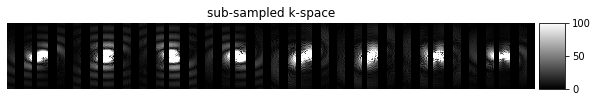

In [26]:
shepp_upat = shepp * mask[...,None,None]
bart_plot(unravel(shepp_upat), title='sub-sampled k-space', vmax=100)

Note that we used numpy broadcasting to automatically apply the mask to each coil.

After creating the under-sample data, we now first perform a simple reconstruction using an inverse Fourier transform (`fft`) and root-sum-of-squares coil combination (`rss`).

Builtin found: fft
md_mul optimized by blas_mul_sscal: 
 Old dims/strides:
[  2 256 256   1   8 ]
[  4   8 2048   0 524288 ]
[  4   8 2048   0 524288 ]
[  0   0   0   0   0 ]
optimized dims/strides (N=1 by strided kernel):
[1048576 ]
[  4 ]
[  4 ]
[  0 ]
Builtin found: rss


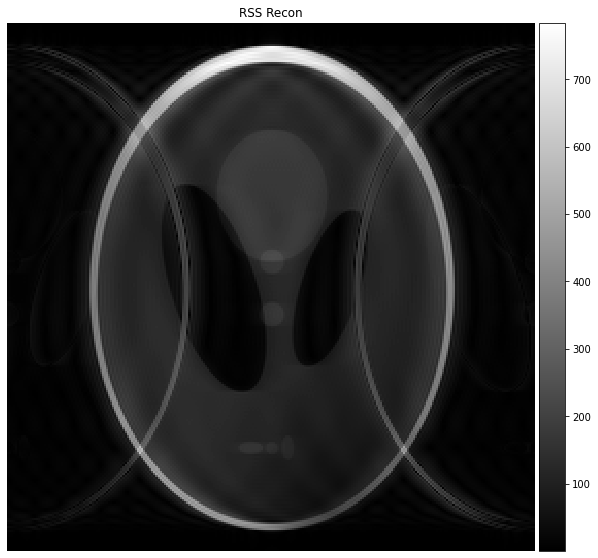

In [27]:
# simple IFFT + RSS reconstruction

# perform inverse FFT. Use the unitary flag for unitary transform
shepp_fft = bart(1, 'fft -iu 3', shepp_upat)

# RSS-combine
shepp_rss = bart(1, 'rss 8', shepp_fft)

bart_plot(shepp_rss, title='RSS Recon')

The result is (of course) not very good. The image is corrupted with aliasing artifacts due to the equispaced subsampling.

Let's try a more advanced reconstruction technique. We will first determine the coil sensitivities. Here, we use the ESPIRiT algorithm to obtain the sensitivity maps for each coil. We will now have a closer look at the ESPIRiT `ecalib` tool.

In [28]:
bart(0, 'ecalib -h')

Builtin found: ecalib
Usage: ecalib [-t f] [-c f] [-k d:d:d] [-r d:d:d] [-m d] [-S] [-W] [-I] [-1] [-P] [-v f] [-a] [-d d] <kspace> <sensitivities> [<ev-maps>] 

Estimate coil sensitivities using ESPIRiT calibration.
Optionally outputs the eigenvalue maps.

-t threshold     This determined the size of the null-space.
-c crop_value    Crop the sensitivities if the eigenvalue is smaller than {crop_value}.
-k ksize         kernel size
-r cal_size      Limits the size of the calibration region.
-m maps          Number of maps to compute.
-S               create maps with smooth transitions (Soft-SENSE).
-W               soft-weighting of the singular vectors.
-I               intensity correction
-1               perform only first part of the calibration
-P               Do not rotate the phase with respect to the first principal component
-v variance      Variance of noise in data.
-a               Automatically pick thresholds.
-d level         Debug level
-h               help


The default number of maps is 2. For simplicity we will only use one set of coil sensitivities in this example by using the option `-m 1`.

Builtin found: ecalib
Calibration region...  (size: 24x21x1, pos: 116x117x0)
Energy: 0.596 0.282 0.102 0.015 0.004 0.001 0.000 0.000
Build calibration matrix and SVD...
Eigen decomposition... (size: 288)
Using 47/288 kernels (16.32%, last SV: 0.034088).
SVALS 66989.851562 (1.000000)
SVALS 62253.683594 (0.929300)
SVALS 53210.175781 (0.794302)
SVALS 43408.460938 (0.647986)
SVALS 41812.957031 (0.624169)
SVALS 38295.855469 (0.571667)
SVALS 38016.652344 (0.567499)
SVALS 36160.199219 (0.539786)
SVALS 34774.492188 (0.519101)
SVALS 34356.781250 (0.512865)
SVALS 33495.585938 (0.500010)
SVALS 32057.214844 (0.478538)
SVALS 31198.093750 (0.465714)
SVALS 29487.386719 (0.440177)
SVALS 28111.398438 (0.419637)
SVALS 27181.154297 (0.405750)
SVALS 25885.837891 (0.386414)
SVALS 23668.580078 (0.353316)
SVALS 23115.986328 (0.345067)
SVALS 21467.363281 (0.320457)
SVALS 20927.347656 (0.312396)
SVALS 20032.517578 (0.299038)
SVALS 19505.800781 (0.291175)
SVALS 17811.681641 (0.265886)
SVALS 17041.027344 (0.2543

[  0  12  96 24576 ]
  0 24576 ]
 12 [[ 36 ]
]
 12   8   0   0   8   1 [ 36  36  36 ]
 96 ]
  0 [[[]
  0   0 ]
[  0   8   0  36 optimized dims/strides (N=1 by strided kernel):
]
 96   8 ]
]
  1 [24576 ]
24576 [  0 24576   0   8  36   0  96   0 optimized dims/strides (N=1 by strided kernel):
[ 12   8 [24576   8   0 [24576 ]
[  0 ]
  8 ]
]
[[  0 24576 [  0 24576   8 ]
 12 24576 24576 []
md_zmul optimized by blas_zmul_cscal: 
 Old dims/strides:
  8 24576   0 ]
  8   8 [ 36 ]
24576 ]
 96   0 ]
]
[24576   0 []
  8  96 [  0 []
]
  0 24576   0   0  36   8   0  12 ]
[md_zmul optimized by blas_zmul_cscal: 
 Old dims/strides:
  0   8 24576 [  1 [  0 []
[[  0   8 ]
 12   0 []
  0 []
 96 24576   0 24576 [  0 ]
  1   0 optimized dims/strides (N=1 by strided kernel):
  1   0 ]
  8 [  0 ]
  8   8 ]
 36   0 24576 []
[ 96 []
  0   8  12 optimized dims/strides (N=1 by strided kernel):
  1 md_zmul optimized by blas_zmul_cscal: 
 Old dims/strides:
]
  8 []
]
[optimized dims/strides (N=1 by strided kernel)

]
  0   0 []
]
  8   8 [  1   0 ]
optimized dims/strides (N=1 by strided kernel):
[[[  0   0 ]
]
  8 24576   8   0   0   1 []
md_zmul optimized by blas_zmul_cscal: 
 Old dims/strides:
  8 [  0   0 [  0 md_zmul optimized by blas_zmul_cscal: 
 Old dims/strides:
 36 24576   8   8 []
[  8  96 24576 [  0 ]
 96 [[  0 24576 24576  96   0 ]
]
  0   8   0  96   8  96 [ 12 ]
 12 []
 12   0 ]
24576   0 ]
24576 24576 ]
  0 [ 36   0 24576   0 ]
md_zmul optimized by blas_zmul_cscal: 
 Old dims/strides:
md_zmul optimized by blas_zmul_cscal: 
 Old dims/strides:
  1 ]
[]
]
  0 [  1 24576 24576   0 [  1 [[]
 12 ]
  0   8 ]
  0  96   0  12   8  36 [  0   0 optimized dims/strides (N=1 by strided kernel):
]
[24576   0 [  8 [[  8   1 ]
]
  1  96 [[  8   1 optimized dims/strides (N=1 by strided kernel):
  0  36 optimized dims/strides (N=1 by strided kernel):
 12   0 []
  1 ]
]
  1   0 24576  36   8   0 md_zmul optimized by blas_zmul_cscal: 
 Old dims/strides:
]
[  0 [24576  96 md_zmul optimized by blas_zmul_

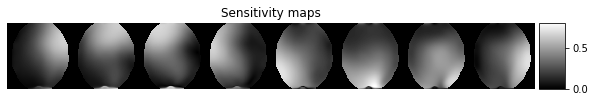

In [29]:
# compute sensitivity maps with ESPIRiT
sens_maps = bart(1, 'ecalib -m1', shepp_upat)

bart_plot(unravel(sens_maps), title='Sensitivity maps')

Given the sensitivities, we can use the `pics` command to perform iterative parallel imaging reconstruction using various regularization terms. It solves the folllowing minimization problem:

$\arg\min_x ||PFS x - y|| + \lambda R(x)$, where:
- $P$ is the sampling operator
- $F$ is the Fourier transform
- $S$ is the multiplication with the sensitivity maps
- $x$ is the unknown image
- $y$ are the acquired multi-coil k-space data
- $R$ is a regularization functional
- $\lambda$ is the regularization weighting parameter

A popular regularization is $\ell_2$, i.e. $R(x) = ||x||_2^2$.

The objective function then corresponds to a SENSE reconstruction.

Builtin found: pics
Size: 65536 Samples: 35328 Acc: 1.86
md_mul optimized by blas_mul_sscal: 
 Old dims/strides:
[  2 256 256   1   8 ]
[  4   8 2048   0 524288 ]
[  4   8 2048   0 524288 ]
[  0   0   0   0   0 ]
optimized dims/strides (N=1 by strided kernel):
[1048576 ]
[  4 ]
[  4 ]
[  0 ]
Calibration region...  (size: 32x21x1, pos: 113x117x0)
md_mul optimized by blas_mul_sscal: 
 Old dims/strides:
[  2  32  21   1   8 ]
[  4   8 256   0 5376 ]
[  4   8 256   0 5376 ]
[  0   0   0   0   0 ]
optimized dims/strides (N=1 by strided kernel):
[10752 ]
[  4 ]
[  4 ]
[  0 ]
Scaling: 642.546265! (max = 642.546265/p90 = 185.546982/median = 53.019684)
Inverse scaling of the data: 642.546265
md_mul optimized by blas_mul_sscal: 
 Old dims/strides:
[  2 256 256   1   8 ]
[  4   8 2048   0 524288 ]
[  4   8 2048   0 524288 ]
[  0   0   0   0   0 ]
optimized dims/strides (N=1 by strided kernel):
[1048576 ]
[  4 ]
[  4 ]
[  0 ]
l2 regularization: 0.005000
Regularization terms: 1, Supporting variable

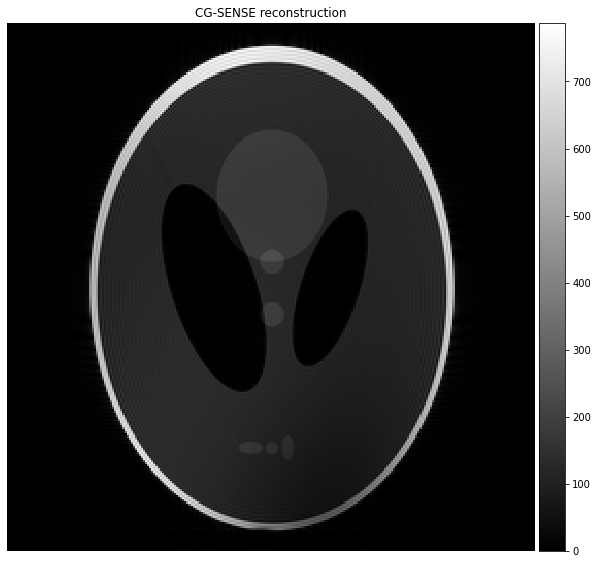

In [30]:
lamda = 0.005
num_iter = 50

# parallel imaging reconstruction using l2 regularization
shepp_l2 = bart(1, 'pics -S -l2 -r {} -i {}'.format(lamda, num_iter), shepp_upat, sens_maps)

bart_plot(shepp_l2, 'CG-SENSE reconstruction')

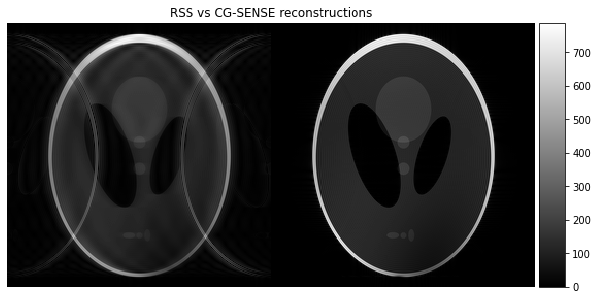

In [31]:
# combine images for display

bart_plot(np.concatenate((shepp_rss, shepp_l2), 1), title='RSS vs CG-SENSE reconstructions')

## Reconstructing data from the scanner

Because the BART file format is simple, it is possible to read data from many different sources. The BART command includes the `twixread` tool for basic reading of Siemens `.dat` files. We also include GE Orchestra libraries for reading P-File and ScanArchives, called [ox-bart](https://github.com/mrirecon/ox-bart).

In the data folder, we have already converted a k-space dataset from a vendor-specific format to BART format. The files are the following:

- `ksp`: Raw k-space data
- `ref`: Autocalibration reference scan
- `noise`: Noise pre-scan

We will use all three for reconstruction

In [32]:
! echo "ksp:"
! bart show -m ksp
! echo
! echo "ref:"
! bart show -m ref
! echo
! echo "noise:"
! bart show -m noise

ksp:
Builtin found: show
Type: complex float
Dimensions: 16
AoD:	768	382	1	16	1	1	1	1	1	1	1	1	1	1	1	1

ref:
Builtin found: show
Type: complex float
Dimensions: 16
AoD:	768	33	1	16	1	1	1	1	1	1	1	1	1	1	1	1

noise:
Builtin found: show
Type: complex float
Dimensions: 16
AoD:	768	1	1	16	1	1	1	1	1	1	1	1	1	1	1	1


In [33]:
# load data into Python
ksp = cfl.readcfl('ksp')
print('ksp:', ksp.shape)

ref = cfl.readcfl('ref')
print('ref:', ref.shape)

noise = cfl.readcfl('noise')
print('noise:', noise.shape)

ksp: (768, 382, 1, 16)
ref: (768, 33, 1, 16)
noise: (768, 1, 1, 16)


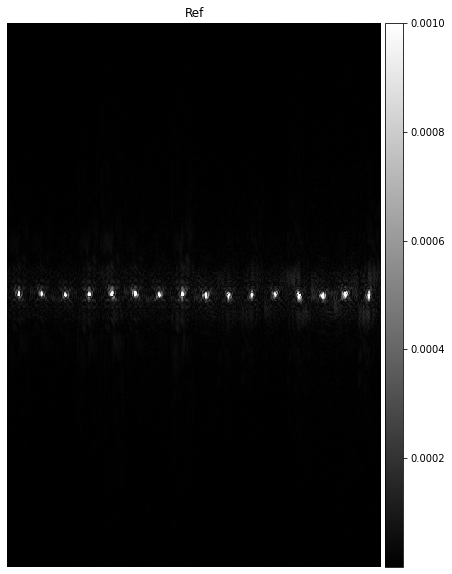

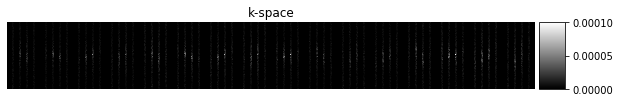

In [34]:
bart_plot(unravel(ref), title='Ref', vmax=.001)
bart_plot(unravel(ksp), title='k-space', vmax=.0001)

Based on the array sizes and dimensions, we can infer that the readout dimension is 768 samples, the phase encode dimension is 382, and there are 16 coils. Notice that the reference scan has 33 phase-encode ACS lines.


Our scanner automatically doubles the FOV in the readout dimension.

As first steps, let's (1) crop the data in the readout dimension to FOV/2, and (2) zero-pad the ref data to be the same phase-encode size as the k-space data. Then let's perform IFFTs and look at them in the image domain.

Builtin found: fft
md_mul optimized by blas_mul_sscal: 
 Old dims/strides:
[  2 768 382   1  16 ]
[  4   8 6144   0 2347008 ]
[  4   8 6144   0 2347008 ]
[  0   0   0   0   0 ]
optimized dims/strides (N=1 by strided kernel):
[9388032 ]
[  4 ]
[  4 ]
[  0 ]
Builtin found: resize
Builtin found: fft
md_mul optimized by blas_mul_sscal: 
 Old dims/strides:
[  2 384 382   1  16 ]
[  4   8 3072   0 1173504 ]
[  4   8 3072   0 1173504 ]
[  0   0   0   0   0 ]
optimized dims/strides (N=1 by strided kernel):
[4694016 ]
[  4 ]
[  4 ]
[  0 ]
Builtin found: fft
md_mul optimized by blas_mul_sscal: 
 Old dims/strides:
[  2 768  33   1  16 ]
[  4   8 6144   0 202752 ]
[  4   8 6144   0 202752 ]
[  0   0   0   0   0 ]
optimized dims/strides (N=1 by strided kernel):
[811008 ]
[  4 ]
[  4 ]
[  0 ]
Builtin found: resize
Builtin found: fft
md_mul optimized by blas_mul_sscal: 
 Old dims/strides:
[  2 384  33   1  16 ]
[  4   8 3072   0 101376 ]
[  4   8 3072   0 101376 ]
[  0   0   0   0   0 ]
optimized dim

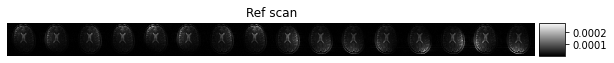

Builtin found: fft
md_mul optimized by blas_mul_sscal: 
 Old dims/strides:
[  2 384 382   1  16 ]
[  4   8 3072   0 1173504 ]
[  4   8 3072   0 1173504 ]
[  0   0   0   0   0 ]
optimized dims/strides (N=1 by strided kernel):
[4694016 ]
[  4 ]
[  4 ]
[  0 ]


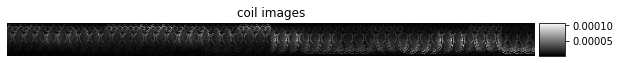

In [35]:
ksp_crop = bart(1, 'fft -u 1', bart(1, 'resize -c 0 {}'.format(ksp.shape[0]//2), bart(1, 'fft -iu 1', ksp)))
ref_crop = bart(1, 'fft -u 1', bart(1, 'resize -c 0 {}'.format(ref.shape[0]//2), bart(1, 'fft -iu 1', ref)))

ref_zpad = bart(1, 'resize -c 1 {}'.format(ksp_crop.shape[1]), ref_crop)
bart_plot(unravel(bart(1, 'fft -iu 3', ref_zpad)), title='Ref scan')
bart_plot(unravel(bart(1, 'fft -iu 3', ksp_crop)), title='coil images')

## Noise pre-whitening
Before reconstruction, it is a good idea to do noise pre-whitening. Most vendors should provide you with a noise pre-scan. If not, then you should complain to your vendor!

We can use the BART `whiten` tool to inspect the covariance matrix and create a noise prewhitening matrix.

In [36]:
bart(0, 'whiten -h')

Builtin found: whiten
Usage: whiten [-o <file>] [-c <file>] [-n] <input> <ndata> <output> [<optmat_out>] [<covar_out>] 

Apply multi-channel noise pre-whitening on <input> using noise data <ndata>.
Optionally output whitening matrix and noise covariance matrix

-o <optmat_in>    use external whitening matrix <optmat_in>
-c <covar_in>     use external noise covariance matrix <covar_in>
-n                normalize variance to 1 using noise data <ndata>
-h                help


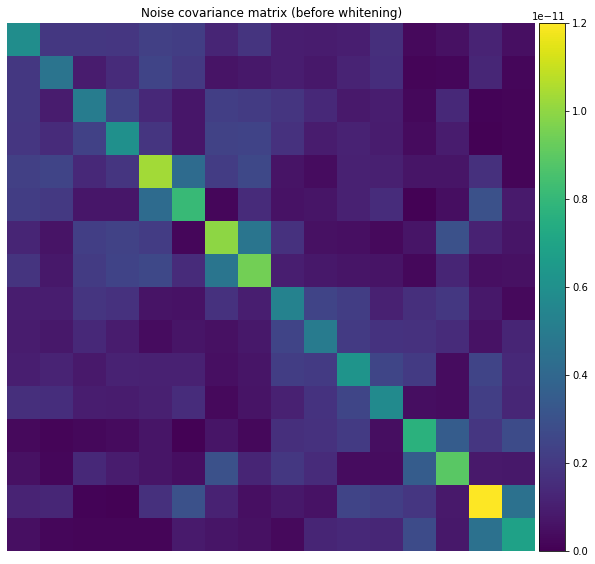

Builtin found: whiten
md_zfmacc optimized by blas_zfmac_cgemm: 
 Old dims/strides:
[768   1   1  16  16 ]
[  0   0   0   8 128 ]
[  8   0   0 6144   0 ]
[  8   0   0   0 6144 ]
optimized dims/strides (N=3 by strided kernel):
[ 16 768  16 ]
[  8   0 128 ]
[6144   8   0 ]
[  0   8 6144 ]
md_mul optimized by blas_mul_sscal: 
 Old dims/strides:
[  2   1   1   1  16  16 ]
[  4   0   0   0   8 128 ]
[  4   0   0   0   8 128 ]
[  0   0   0   0   0   0 ]
optimized dims/strides (N=1 by strided kernel):
[512 ]
[  4 ]
[  4 ]
[  0 ]
md_zfmac optimized by blas_zfmac_cdotu: 
 Old dims/strides:
[12288 ]
[  0 ]
[  8 ]
[  8 ]
optimized dims/strides (N=1 by strided kernel):
[12288 ]
[  0 ]
[  8 ]
[  8 ]
md_zadd optimized by reduce_zadd_gemv: 
 Old dims/strides:
[768   1   1  16 ]
[  0   0   0   0 ]
[  0   0   0   0 ]
[  8   0   0 6144 ]
optimized dims/strides (N=1 by strided kernel):
[12288 ]
[  0 ]
[  0 ]
[  8 ]
md_mul optimized by blas_mul_sscal: 
 Old dims/strides:
[  2 ]
[  4 ]
[  4 ]
[  0 ]
optimiz

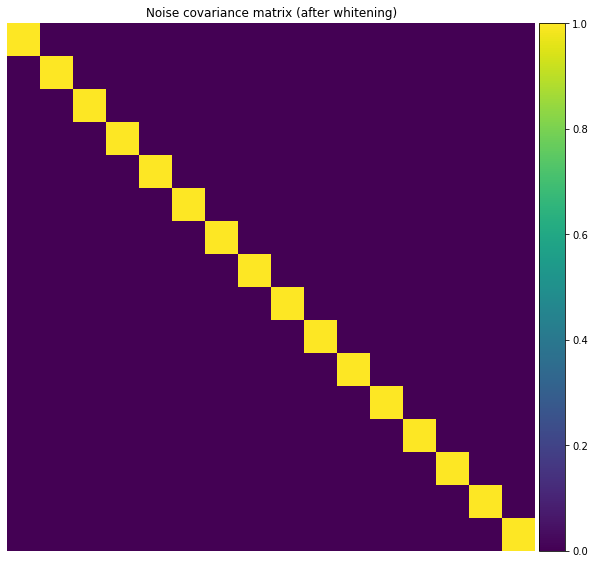

In [37]:
noise_cov = np.conj(noise.squeeze()).T @ noise.squeeze() / (noise.shape[0] - 1)
bart_plot(noise_cov, cmap='viridis', vmin=0, title='Noise covariance matrix (before whitening)')

noise_white = bart(1, 'whiten -n', noise, noise)
noise_white_cov = np.conj(noise_white.squeeze()).T @ noise_white.squeeze() / (noise_white.shape[0] - 1)
bart_plot(noise_white_cov, cmap='viridis', vmin=0, title='Noise covariance matrix (after whitening)')


Builtin found: whiten
md_zfmacc optimized by blas_zfmac_cgemm: 
 Old dims/strides:
[768   1   1  16  16 ]
[  0   0   0   8 128 ]
[  8   0   0 6144   0 ]
[  8   0   0   0 6144 ]
optimized dims/strides (N=3 by strided kernel):
[ 16 768  16 ]
[  8   0 128 ]
[6144   8   0 ]
[  0   8 6144 ]
md_mul optimized by blas_mul_sscal: 
 Old dims/strides:
[  2   1   1   1  16  16 ]
[  4   0   0   0   8 128 ]
[  4   0   0   0   8 128 ]
[  0   0   0   0   0   0 ]
optimized dims/strides (N=1 by strided kernel):
[512 ]
[  4 ]
[  4 ]
[  0 ]
md_zfmac optimized by blas_zfmac_cdotu: 
 Old dims/strides:
[12288 ]
[  0 ]
[  8 ]
[  8 ]
optimized dims/strides (N=1 by strided kernel):
[12288 ]
[  0 ]
[  8 ]
[  8 ]
md_zadd optimized by reduce_zadd_gemv: 
 Old dims/strides:
[768   1   1  16 ]
[  0   0   0   0 ]
[  0   0   0   0 ]
[  8   0   0 6144 ]
optimized dims/strides (N=1 by strided kernel):
[12288 ]
[  0 ]
[  0 ]
[  8 ]
md_mul optimized by blas_mul_sscal: 
 Old dims/strides:
[  2 ]
[  4 ]
[  4 ]
[  0 ]
optimiz

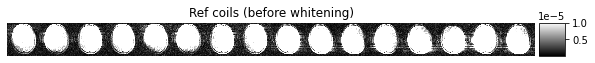

Builtin found: fft
md_mul optimized by blas_mul_sscal: 
 Old dims/strides:
[  2 384 382   1  16 ]
[  4   8 3072   0 1173504 ]
[  4   8 3072   0 1173504 ]
[  0   0   0   0   0 ]
optimized dims/strides (N=1 by strided kernel):
[4694016 ]
[  4 ]
[  4 ]
[  0 ]


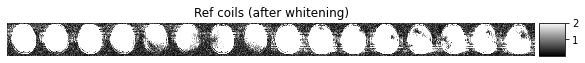

In [38]:
ksp_white = bart(1, 'whiten -n', ksp_crop, noise)
ref_white = bart(1, 'whiten -n', ref_crop, noise)

ref_white_zpad = bart(1, 'resize -c 1 {}'.format(ksp_crop.shape[1]), ref_white)
bart_plot(unravel(bart(1, 'fft -iu 3', ref_zpad)), title='Ref coils (before whitening)', vmax=.00001)
bart_plot(unravel(bart(1, 'fft -iu 3', ref_white_zpad)), title='Ref coils (after whitening)', vmax=2)

#### Coil Compression
To reduce the size of our dataset and therefore also decrease the computational complexity, we perform a coil compression with the `cc` command.

We will do coil compression in 2 steps. We will first use ``cc` on the reference data to create the coil compression matrix. We will then use ``ccapply` to apply it to both the reference data and to the k-space data. This way we use the same coil compression matrix for both arrays.

By passing `-A` we choose to use all possible data and to reduce the dataset to 8 virtual coils with `-p`.


In [39]:
cc_mat = bart(1, 'cc -A', ref_white)

ref_white_cc = bart(1, 'ccapply -p 8', ref_white, cc_mat)
ref_white_cc_zpad = bart(1, 'resize -c 1 {}'.format(ksp_crop.shape[1]), ref_white_cc)

ksp_white_cc = bart(1, 'ccapply -p 8', ksp_white, cc_mat)

print(ksp_white_cc.shape)

Builtin found: cc
Energy: 0.354 0.331 0.202 0.068 0.014 0.010 0.008 0.004 0.004 0.001 0.001 0.000 0.000 0.000 0.000 0.000
Done.
Builtin found: ccapply
Compressing to 8 virtual coils...
md_zfmacc optimized by blas_zfmac_cgemm: 
 Old dims/strides:
[384  33   1  16   8 ]
[  8 3072   0   0 101376 ]
[  8 3072   0 101376   0 ]
[  0   0   0   8 128 ]
optimized dims/strides (N=3 by strided kernel):
[12672  16   8 ]
[  8   0 101376 ]
[  8 101376   0 ]
[  0   8 128 ]
Done.
Builtin found: resize
Builtin found: ccapply
Compressing to 8 virtual coils...
md_zfmacc optimized by blas_zfmac_cgemm: 
 Old dims/strides:
[384 382   1  16   8 ]
[  8 3072   0   0 1173504 ]
[  8 3072   0 1173504   0 ]
[  0   0   0   8 128 ]
optimized dims/strides (N=3 by strided kernel):
[146688  16   8 ]
[  8   0 1173504 ]
[  8 1173504   0 ]
[  0   8 128 ]
Done.
(384, 382, 1, 8)


#### RSS reconstructions
Let's do simple RSS reconstructions of the reference and subsampled data

Builtin found: fft
md_mul optimized by blas_mul_sscal: 
 Old dims/strides:
[  2 384 382   1   8 ]
[  4   8 3072   0 1173504 ]
[  4   8 3072   0 1173504 ]
[  0   0   0   0   0 ]
optimized dims/strides (N=1 by strided kernel):
[2347008 ]
[  4 ]
[  4 ]
[  0 ]
Builtin found: rss
Builtin found: fft
md_mul optimized by blas_mul_sscal: 
 Old dims/strides:
[  2 384 382   1   8 ]
[  4   8 3072   0 1173504 ]
[  4   8 3072   0 1173504 ]
[  0   0   0   0   0 ]
optimized dims/strides (N=1 by strided kernel):
[2347008 ]
[  4 ]
[  4 ]
[  0 ]
Builtin found: rss


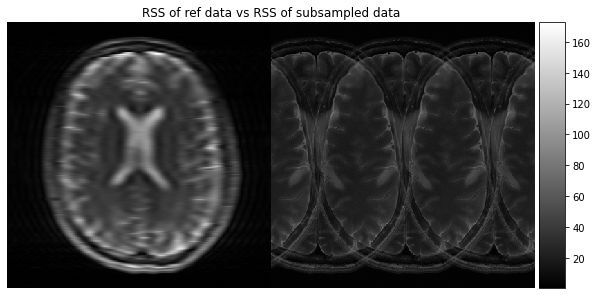

In [40]:
ref_rss = bart(1, 'rss 8', bart(1, 'fft -iu 3', ref_white_cc_zpad)).real
ksp_rss = bart(1, 'rss 8 ', bart(1, 'fft -iu 3', ksp_white_cc)).real

bart_plot(np.concatenate((ref_rss, ksp_rss), 1), title='RSS of ref data vs RSS of subsampled data')

#### Coil Sensitivity Estimation

The coil profile estimation is similar to the case with the phantom data, except it is  applied to the ref scan.

Builtin found: ecalib
Calibration region...  (size: 24x24x1, pos: 181x179x0)
Energy: 0.357 0.343 0.199 0.066 0.013 0.010 0.008 0.004
Build calibration matrix and SVD...
Eigen decomposition... (size: 288)
Using 56/288 kernels (19.44%, last SV: 0.033726).
SVALS 24862.083984 (1.000000)
SVALS 23886.675781 (0.960767)
SVALS 21851.970703 (0.878928)
SVALS 20829.335938 (0.837795)
SVALS 20758.773438 (0.834957)
SVALS 19995.507812 (0.804257)
SVALS 19382.453125 (0.779599)
SVALS 19111.273438 (0.768692)
SVALS 18732.998047 (0.753477)
SVALS 17854.886719 (0.718157)
SVALS 17311.478516 (0.696300)
SVALS 16614.275391 (0.668258)
SVALS 16394.927734 (0.659435)
SVALS 15999.118164 (0.643515)
SVALS 15460.617188 (0.621855)
SVALS 14892.473633 (0.599003)
SVALS 14377.383789 (0.578286)
SVALS 14116.398438 (0.567788)
SVALS 12842.949219 (0.516568)
SVALS 12196.648438 (0.490572)
SVALS 11450.787109 (0.460572)
SVALS 10923.253906 (0.439354)
SVALS 10427.776367 (0.419425)
SVALS 9462.744141 (0.380609)
SVALS 9144.248047 (0.367799

Calculate Gram matrix...
Resize...
md_zmul optimized by blas_zmul_cscal: 
 Old dims/strides:
md_zmul optimized by blas_zmul_cscal: 
 Old dims/strides:
md_zmul optimized by blas_zmul_cscal: 
 Old dims/strides:
md_zmul optimized by blas_zmul_cscal: 
 Old dims/strides:
md_zmul optimized by blas_zmul_cscal: 
 Old dims/strides:
[md_zmul optimized by blas_zmul_cscal: 
 Old dims/strides:
[ 12 md_zmul optimized by blas_zmul_cscal: 
 Old dims/strides:
[ 12   1 md_zmul optimized by blas_zmul_cscal: 
 Old dims/strides:
[ 12   1   1  36 ]
[  8 md_zmul optimized by blas_zmul_cscal: 
 Old dims/strides:
[ 12   1 [ 12 md_zmul optimized by blas_zmul_cscal: 
 Old dims/strides:
md_zmul optimized by blas_zmul_cscal: 
 Old dims/strides:
  1   1  36   1   1 [[  1  12   1   1  12   1 md_mul optimized by blas_mul_sscal: 
 Old dims/strides:
[ 12  36   1   1 ]
[ 36  36 []
  2  12   1 ]
  1   1  36  36   1 ]
 36  36 ]
 12 ]
 12   1 [  1 []
[[[[[  1   4   8 ]
  8   8  96  96   8   8 [  0   8   1   0  96  96  12  

  8 36672 [  8 ]
  1 ]
 12   0 [36672   0 []
]
  0 ]
  1  36  36 [ 36 md_zmul optimized by blas_zmul_cscal: 
 Old dims/strides:
36672  36   0   0   8 [  0   8 optimized dims/strides (N=1 by strided kernel):
[ 96 36672   1 ]
[  0   8 ]
[36672 ]
]
]
]
  0  12 36672 [[  8  12   8  36   8 md_zmul optimized by blas_zmul_cscal: 
 Old dims/strides:
36672 36672 ]
 96 ]
]
36672 optimized dims/strides (N=1 by strided kernel):
  0 36672 []
[]
]
]
[[[ 36 [[  8 [  0 []
[ 12 ]
 12   8   1   0   8 36672 [  1 [  0 ]
[md_zmul optimized by blas_zmul_cscal: 
 Old dims/strides:
  8 ]
[  8   1   8 ]
  0 [36672  36 36672   1 36672 [ 36  12   0 36672 ]
  8 [  8 ]
 96 36672   0 ]
]
  8  36   0 ]
[  8 ]
md_zmul optimized by blas_zmul_cscal: 
 Old dims/strides:
[ 36 []
36672 md_zmul optimized by blas_zmul_cscal: 
 Old dims/strides:
  0 [ 12 [ 96 []
  8 [ 12 ]
[36672 ]
  0   8 ]
[36672 ]
  1   1   1   8 36672  12   0  36 [  0   1 ]
36672   0 [  0   8 [  8   0 ]
]
36672 36672   1 []
]
]
  8 [  0 ]
  0 ]
[  0 [  0

[md_zmul optimized by blas_zmul_cscal: 
 Old dims/strides:
[ 12   1   1  36 ]
[  8  96   0 36672 ]
[  8  96   0 36672 ]
[  0   0   0   0 ]
optimized dims/strides (N=1 by strided kernel):
[ 12  36 ]
[  8 36672 ]
[  8 36672 ]
[  0   0 ]
  0   0 36672 ]
[  0   0   0   0 ]
optimized dims/strides (N=1 by strided kernel):
[ 12  36 ]
[  8 36672 ]
[  8 36672 ]
[  0   0 ]
md_zmul optimized by blas_zmul_cscal: 
 Old dims/strides:
md_zmul optimized by blas_zmul_cscal: 
 Old dims/strides:
[ 12 [  8   0  96   0  96 [  0 [36672   8  36 ]
 12 md_zmul optimized by blas_zmul_cscal: 
 Old dims/strides:
36672  12   0   0 36672 ]
[ 12  36 ]
  0 [[  0 ]
]
[  1 [optimized dims/strides (N=1 by strided kernel):
  0 [  8 36672   8 optimized dims/strides (N=1 by strided kernel):
[  1  36 36672   8  96   0 ]
[  8 [  1  96 36672 [36672 ]
  0 [ 12 ]
 12  12   1   0   1  36   0 36672   1 [  8  36   8 ]
]
 12  12 []
[  1  36  12   8 ]
 96   1  96 ]
]
[ 36   0 [  8   0  36   0 ]
[  8   1   8 36672   8 36672   0  96  

  1 [ 96  96 36672   1   0   8 [  8 optimized dims/strides (N=1 by strided kernel):
md_zmul optimized by blas_zmul_cscal: 
 Old dims/strides:
]
[  1 [  0 ]
36672   0 36672   1 [36672   8 [[]
[[]
 36  12  12   0   8  12 []
 96   8  96 [36672   0 ]
[  8 [ 96  36   0  96  36   0  36 ]
]
 96   0  12   1   1   1 ]
]
]
  0 [md_zmul optimized by blas_zmul_cscal: 
 Old dims/strides:
  0   0  36 ]
36672   0   0 [  1 [[36672 [36672  36 ]
  8 [ 36 36672 ]
]
]
  8  12   0 ]
[  8 ]
md_zmul optimized by blas_zmul_cscal: 
 Old dims/strides:
36672  96 [36672   0   0 ]
36672 ]
  8 [  8 [md_zmul optimized by blas_zmul_cscal: 
 Old dims/strides:
36672   8 ]
36672 [  8   8   1  96 ]
  0 [  0   0   8 [[]
[  0  96 ]
36672   0   8 [36672 ]
 96 ]
36672 [  1   0   0 [[]
]
]
 36   0 36672   8  96  12   0  12 [  0   0 [  0  96   0   8 36672 ]
[  1 ]
  8 ]
  0 ]
[[  1 [36672   8   0   0   1  36   0   8  96   8 optimized dims/strides (N=1 by strided kernel):
]
  8 [ 12 36672 ]
 96  96   1 36672   0 [  0 36672   0 

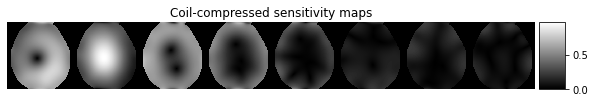

In [41]:
sens_maps = bart(1, 'ecalib -m1', ref_white_cc_zpad)
bart_plot(unravel(sens_maps), title='Coil-compressed sensitivity maps')

#### Parallel imaging reconstruction
We again use `pics` with l2 regularization. This time we use the ref data to get an approximate scale factor and pass it directly to the `pics` command.

In [42]:
# get scale factor from the ref data
scale_factor = np.percentile(ref_rss, 99)
print('reconstruction scale factor: {}'.format(scale_factor))

reconstruction scale factor: 105.921205368042


In [43]:
lamda = .0015
debug_level = 4
reco = bart(1, 'pics -d {} -l2 -r {} -S -w {}'.format(debug_level, lamda, scale_factor), ksp_white_cc, sens_maps)

Builtin found: pics
Size: 146688 Samples: 49151 Acc: 2.98
Inverse scaling of the data: 105.921204
l2 regularization: 0.001500
Regularization terms: 1, Supporting variables: 0
conjugate gradients
	 cg:  30
Total Time: 1.045755


#### Visualize reconstruction

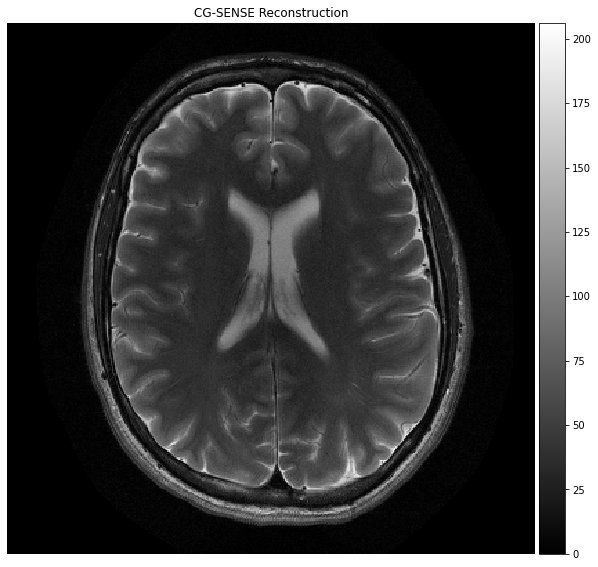

In [44]:
bart_plot(reco, title='CG-SENSE Reconstruction')